# 🐶 End-to-End Mutliclass dog Breed Classificarion

This notebook builds and end-to-wnd mutliclass image classiofier using Tensorflow 2.0 and TensorFlow Hub.

## 1. Problem 

Identifying the breed of the dog given an image of a dog .

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data 

The data we're using is from Kaggle's dog breed data

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation 

The evaluation is a file with prediction probabilities for each dog of each test inage.

## 4. Features 

Some information about the data:
 * We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.

 * There are 120 breeds of dogs (this means theee 120 dofferenrt classes).
 * There are arounf 10,000+ in the training set 
 (these images have labels)
 * There are around 10,000+ in the test set
 (these images have no labels, we'll want to predict to predict them).
 





### Get our workspace ready
* Import Tensorflow 2.x
* Import Tensorflow Hub
* Setting up the GPU

In [1]:
# Import necessery tools

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
print("Tf version: ", tf.__version__)
print("TF hub Version : " , hub.__version__)

# Check for GPU availability

print("GPU", "available (YESSS)" if tf.config.list_physical_devices("GPU") else "not available :(")


Tf version:  2.15.0
TF hub Version :  0.15.0
GPU available (YESSS)


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2024-04-17 18:22:46.669657: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-17 18:22:46.669678: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-17 18:22:46.669687: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-17 18:22:46.669752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-17 18:22:46.669793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
## Let's test the speed of the GPU Compared to the GPU (Macbook 14 M2 PRO)

import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

2024-04-17 18:24:05.380322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-17 18:24:05.380343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-04-17 18:24:05.380776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-17 18:24:05.380786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.8974265420110896
GPU (s):
0.13407608299166895
GPU speedup over CPU: 6x


## Getting our data ready (truning into Tensors)

With all machine learning models, our data has to be in numerical formar. So that's what we'll be doing first Turning our images into Tensors (numerical representation).

Let's start by accessing our data and checking out the labels


In [4]:
# Checkout the labels of our data
import pandas as pd

labels_csv = pd.read_csv("/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: xlabel='breed'>

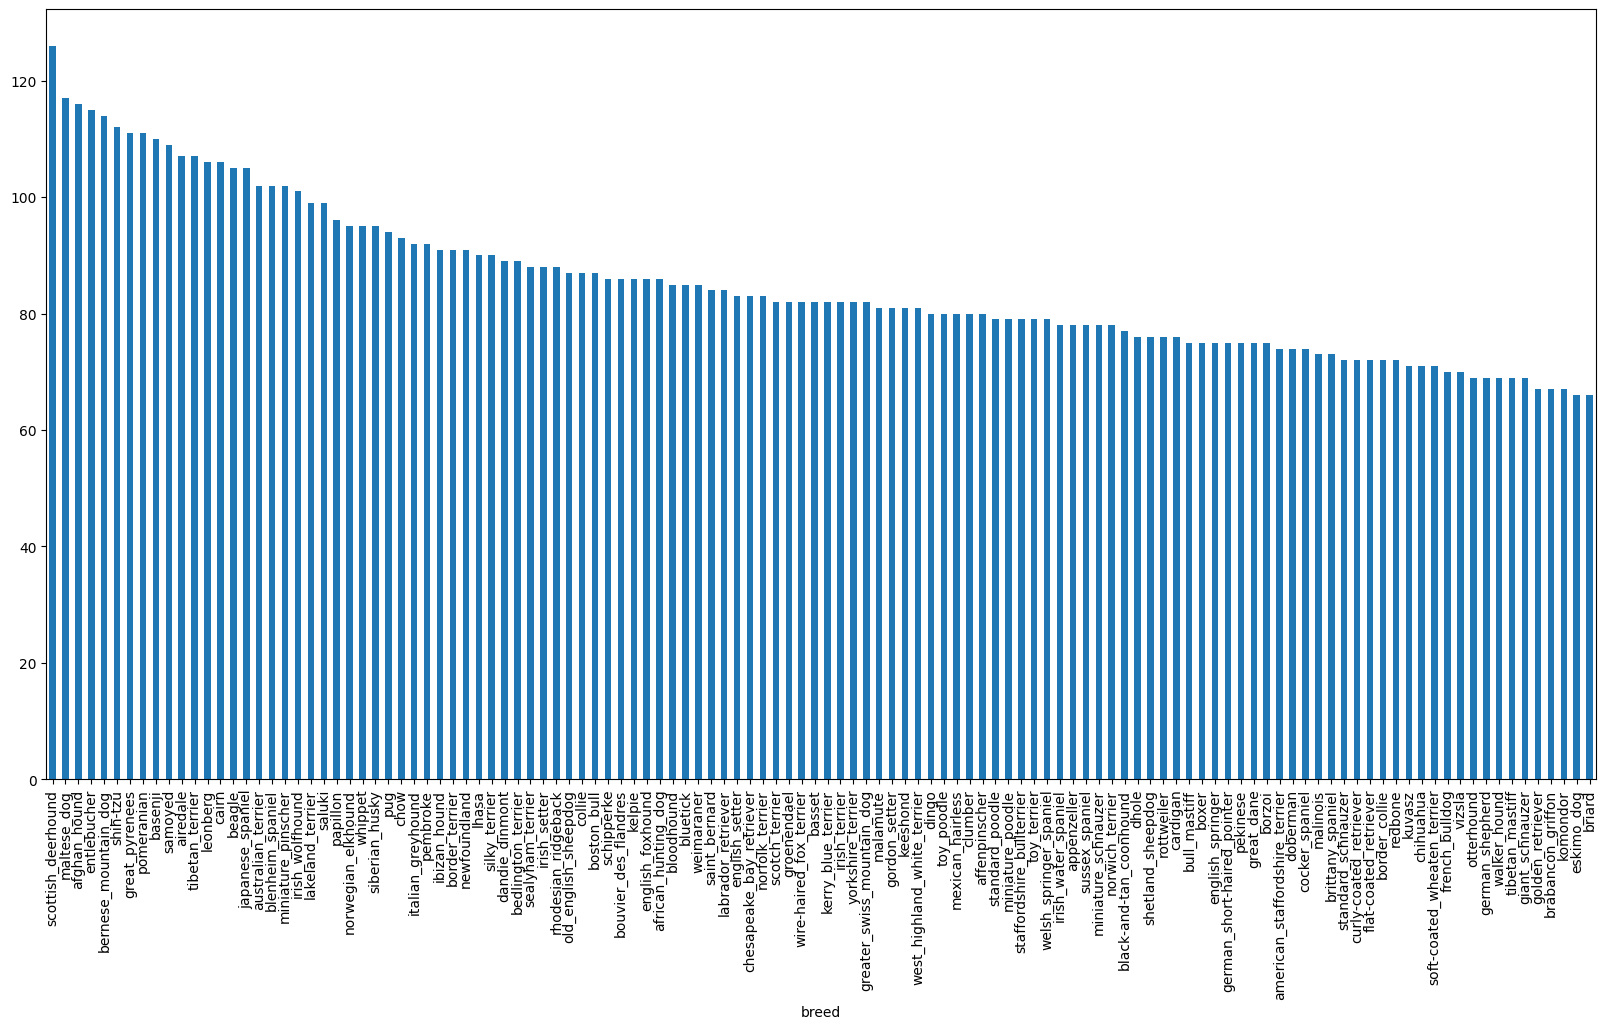

In [5]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [6]:
labels_csv["breed"].value_counts().mean()

85.18333333333334

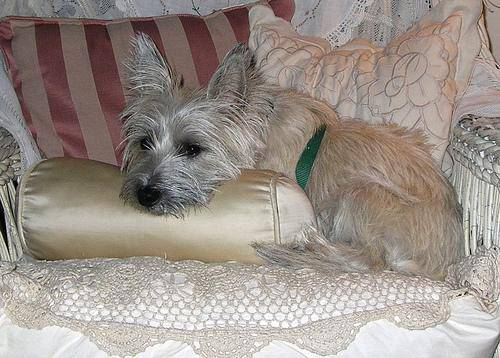

In [7]:
# Let's view an image
from IPython.display import Image
Image("/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/test/0a0f82d4557f70718efa26f8a8a7773f.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames

In [31]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
filenames = ["/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/" + fname +".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f

In [33]:
# Check whether number of filenames matches number of actual image files
import os

if len(os.listdir("/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/")) == len(filenames):
    print("File names match actual amount of files!! Proceed.")
else:
    print("Filenames do no match actual amount of files, check the target directory.")

File names match actual amount of files!! Proceed.


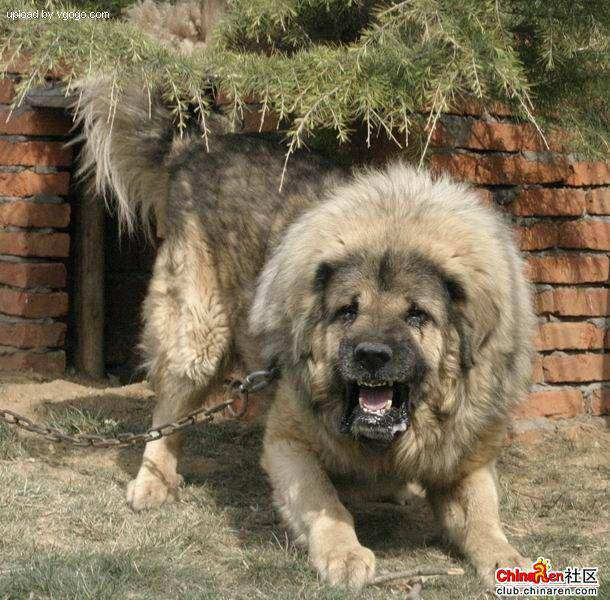

In [34]:
# One more check

Image(filenames[9000])

In [35]:
labels_csv["breed"][9000]

# Since we've now got our training image filepaths in a list, let's prepare our labels

'tibetan_mastiff'

In [36]:
labels = labels_csv["breed"].to_numpy()
#labels = np.array(labels) # same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [37]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("the number matches!!! Proceed.")
else:
    print("The number doesm't match number of filenames")

the number matches!!! Proceed.


In [38]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [39]:
# Turn a single label into an array of bookeans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [40]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]

In [41]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [42]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [43]:
print(labels[2]) # original label
print(np.where(unique_breeds == labels[2])) # index where label occurs
print(boolean_labels[2].argmax()) # index where label occurs in boolean array
print(boolean_labels[2].astype(int)) # there will be a 1 where the sample label occurs

pekinese
(array([85]),)
85
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [44]:
filenames[:10]

['/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f

In [45]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Creating our own validation set
Since the dateset from kaggle doesn't come with a validationset, we should create it by ourselves

In [46]:
##  Setup X & Y variables
X = filenames
y = boolean_labels

In [47]:
# We're going to start off experimenting with ~100i imagexs and increase as needed.
# Set number of images to use for experimenting 

NUM_IMAGES = 1000
NUM_IMAGES

1000

In [48]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES

X_train, X_val , y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                   y[:NUM_IMAGES],
                                                   test_size = 0.2,
                                                   random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [49]:
# Let's have a geew at the training data
X_train[:2], y_train[:2]

(['/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/Users/jihadgarti/Desktop/deep learning/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, image
3. Turn our image (a jpg) into tensors
4. Resize the image to be a shape of(224,224)
5. Return the modified image

## Before we do, Let's see what importing an image looks like.

In [50]:
# Convert image to NumPy

from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [51]:
image.max(), image.min()

(255, 0)

In [52]:
# turn an image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image fielpath as input
2. Use Tensorflow to read the file and save it to a variable, 'image'
3. Turn our 'image' to be a shape of (224,224)
4. Normlize the images
4. Resize the 'image' to be a shape of (224,224)
5. Return the modified 'image'

In [62]:
# Define image size

IMG_SIZE = 224

# Create a function for preprocessing images

def get_image_label(image_path, img_size= IMG_SIZE):
    ''' 
    Turn an image file path and turns the image into a Tensor
    '''
    image = tf.io.read_file(image_path)

    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)

    image = tf.image.decode_jpeg(image, channels=3)

    # Convert the colour channel values from 0-255 to 0-1 values

    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize the image to our desired value

    image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])
    return image


## Turning our data into batches


## Turning our data into batches

Why turn our data into batches

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batches size) images at a time (Oyou can manually adjust the bacthes size if need be)

In order to use tensorflow effectively, we need our data in the form of Tensor tuples which look like this:

In [64]:
# Create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
    """

    Takes an image fle path name ad associeted label,
    processes the image and returns a type of (image, label)
    """
    image = get_image_label(image_path)
    return image, label


In [65]:
(get_image_label(X[42])), tf.constant(y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.32641777, 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.4793749 , 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125177],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634811, 0.03442093

Now we've got a way to turn our data into tuples of tensors in the form: (image, label), let's make a function to turn all of our data (x&y) into batches!

In [67]:
# Define the batch size, 32 is a good start

BATCH_SIZE = 32

# Create a function to turn data into batches

def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data= False, test_data= False):
    """
    Create batches of data out of image(X) and label (y) pairs.

    Shuffles the data if it's training data but doesn't shuffle if it's validation data
    ALso accepts ttest data as input (no labels).
    """

    # If the data is a test dataset, we probably don't have labels

    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    # If the data is a vvalid dateset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # Filepaths
                                                   tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        print("Creating training data batches")

        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffle
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the data into batches

        data_batch = data.batch(BATCH_SIZE)

        return data_batch

In [68]:
# Create training and validation databatches

train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val,y_val, valid_data=True)

Creating training data batches
Creating validation data batches...


In [69]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches 

Our data is now in batches, however , these can be a little hard to understand/ comprehend, let's visualize the data batches

In [78]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch

def show_25_images(images,labels):
    """ 
    Displays a plot of 25 images and their labels from a data batch
    """

    # Setup the figure

    plt.figure(figsize=(10,10))

    # Loop Through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows , 5 columns)
        ax = plt.subplot(5,5,i+1)

        # Display an image
        plt.imshow(images[i])

        # Add the image label as the title

        plt.title(unique_breeds[labels[i].argmax()])

        # turn the grid lines off

        plt.axis("off")

In [79]:
train_images, train_labels = next(train_data.as_numpy_iterator())

len(train_images), len(train_labels)

(32, 32)

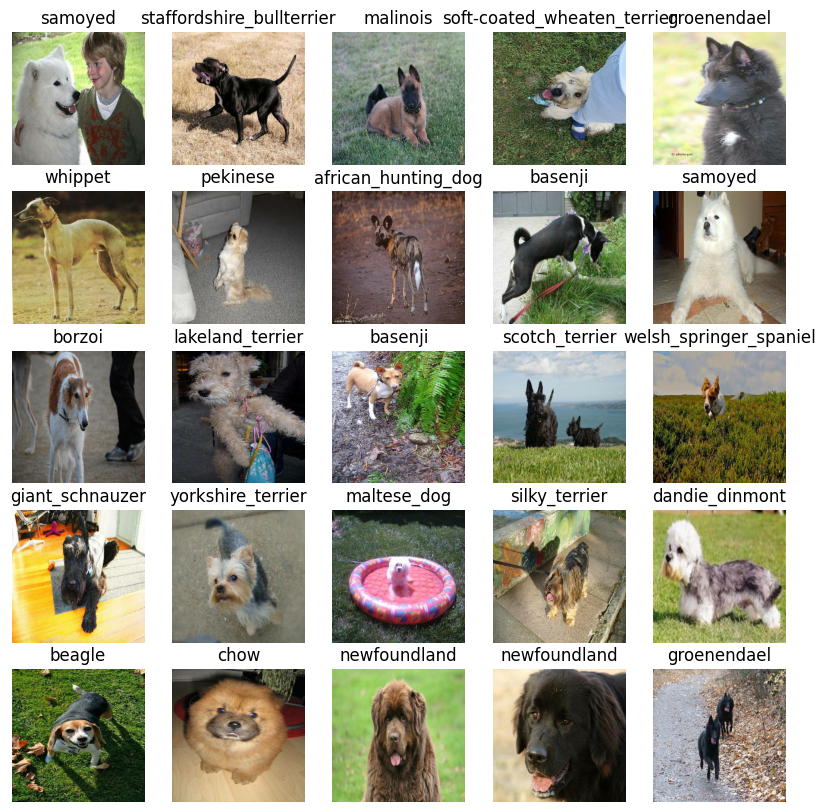

In [81]:
# Now let's visualize the data in a training batch

show_25_images(train_images,train_labels);

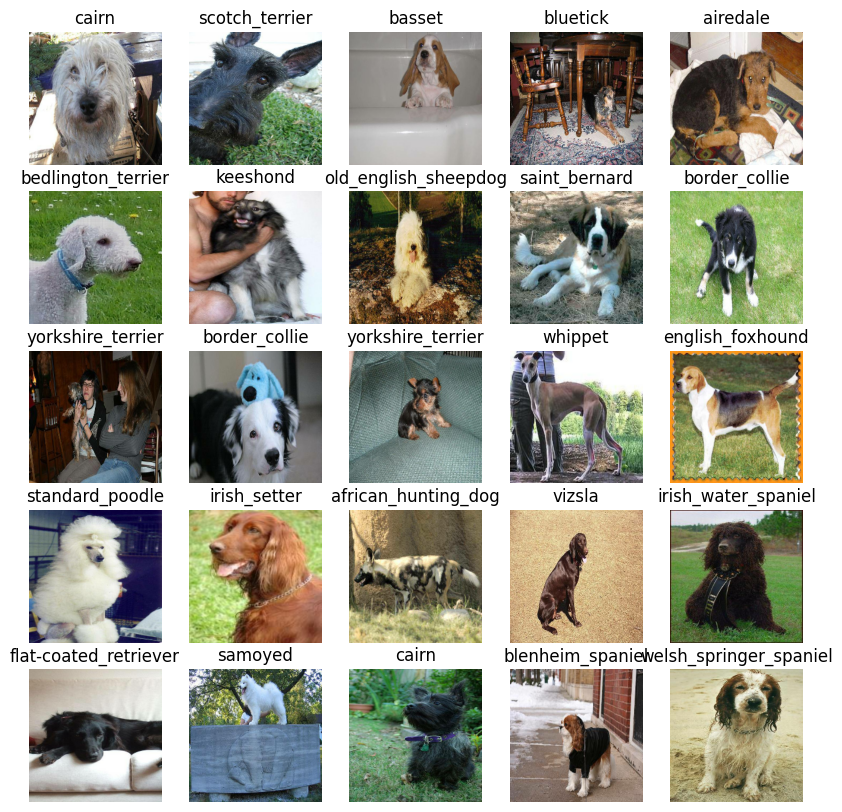

In [82]:
# Now Let's visualize our validation set 

val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)